In [1]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.2 MB/s eta 0:00:00


In [2]:
# colabで非同期処理を実行するために必要
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import stan
import scipy.stats as stats
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

## 問題61

In [4]:
def f_true(x):
    return stats.norm.pdf(x)

def T_n(log_likelihood):
    return -np.mean(np.log(np.mean(np.exp(log_likelihood), axis=0)))

def G_n(y_pred, f_true):
    kde = gaussian_kde(y_pred)
    x = np.linspace(min(y_pred), max(y_pred), 1000)
    f_pred = interp1d(x, kde(x), bounds_error=False, fill_value=1e-15)

    def f_ge(x):
        return f_true(x) * (-np.log(f_pred(x)))

    ge, _ = quad(f_ge, -6, 6)
    return ge

def V_n(log_likelihood):
    return np.mean(np.mean(log_likelihood**2, axis=0) - np.mean(log_likelihood, axis=0)**2)

In [5]:
stan_code = """
data {
  int <lower=0> N;
  vector[N] y;
}

parameters {
  ordered[2] mu;
  real <lower=0, upper=1> theta;
}

model {
  mu ~ normal(0, 2);
  theta ~ beta(5, 5);
  for (n in 1:N)
    target += log_mix(theta,
      normal_lpdf(y[n] | mu[1], 1),
      normal_lpdf(y[n] | mu[2], 1));
}

generated quantities {
  vector[N] log_lik;
  real y_pred;
  for (n in 1:N) {
    log_lik[n] = log_mix(theta,
      normal_lpdf(y[n] | mu[1], 1),
      normal_lpdf(y[n] | mu[2], 1));
    y_pred = theta * normal_rng(mu[1], 1) + (1 - theta) * normal_rng(mu[2], 1);
  }
}
"""

T_stan = []
V_stan = []
G_stan = []
AIC = []
m = 50
n = 200

for j in range(m):
    y = np.random.normal(0, 1, n)
    value = 1/2 * np.log(2 * np.pi * np.e) + 1/2 * np.log(np.var(y) / n * (n-1)) + 3/n/2
    AIC.append(value)
    data_list = {'N': n, 'y': y}

    stan_model = stan.build(stan_code, data=data_list, random_seed=123)
    fit = stan_model.sample(num_samples=6000, num_warmup=1000, num_chains=1)
    ms = fit.to_frame()

    log_lik = np.column_stack([ms[f'log_lik.{i+1}'] for i in range(n)])
    T_stan.append(T_n(log_lik))
    V_stan.append(V_n(log_lik))
    G_stan.append(G_n(ms['y_pred'], f_true))

WAIC_stan = [t_stan + v_stan for t_stan, v_stan in zip(T_stan, V_stan)]
U = 0.5 * np.log(2 * np.pi * np.exp(1)) + 1/n/2
pre_AIC = [aic - 3/n/2 for aic in AIC]


Building...



Building: 34.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000179 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.79 seconds.
  Adjust your expectations accordingly!


Building...


<ipython-input-4-8ada2c4bf204>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ge, _ = quad(f_ge, -6, 6)

Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (9

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling:  59% (4100/7000)
Sampling:  60% (4200/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000111 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.00013 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.3 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  13% (900/7000)
Sampling:  20% (1400/7000)
Sampling:  21% (1500/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 8.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.98 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000111 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000111 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.11 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 8.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.00013 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.3 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000104 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.04 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!


Building...


<ipython-input-4-8ada2c4bf204>:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ge, _ = quad(f_ge, -6, 6)

Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_sj7f376g/model_ctkpoim7.stan', line 16, col

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 0.000122 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0z5snupw/model_ctkpoim7.stan', line 14, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
Sampling:   0%
Sampling:   0% (1/7000)
Sampling:   1% (100/7000)
Sampling:   3% (200/7000)
Sampling:   4% (300/7000)
Sampling:   6% (400/7000)
Sampling:   7% (500/7000)
Sampling:   9% (600/7000)
Sampling:  10% (700/7000)
Sampling:  11% (800/7000)
Sampling:  13% (900/7000)
Sampling: 100% (7000/7000)
Sampling: 100% (7000/7000), done.
Messages received during sampling:
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!


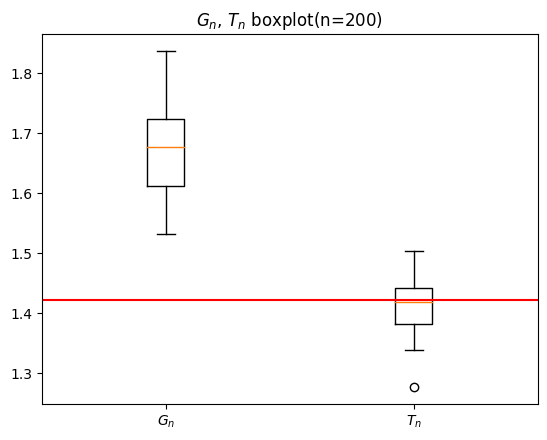

In [6]:
plt.boxplot([G_stan, T_stan], labels=['$G_n$', '$T_n$'])
plt.title('$G_n$, $T_n$ boxplot(n=200)')
plt.axhline(y=U, color='red')
plt.show()

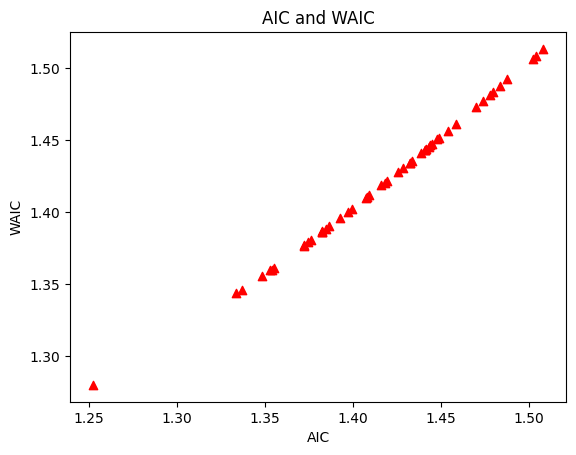

In [7]:
plt.scatter(AIC, WAIC_stan, color='red', marker='^')
plt.xlabel('AIC')
plt.ylabel('WAIC')
plt.title('AIC and WAIC')
plt.show()

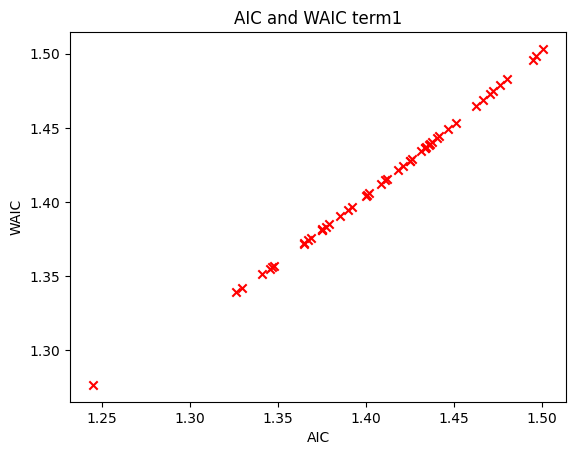

In [8]:
plt.scatter(pre_AIC, T_stan, color='red', marker='x')
plt.xlabel('AIC')
plt.ylabel('WAIC')
plt.title('AIC and WAIC term1')
plt.show()

## 問題64

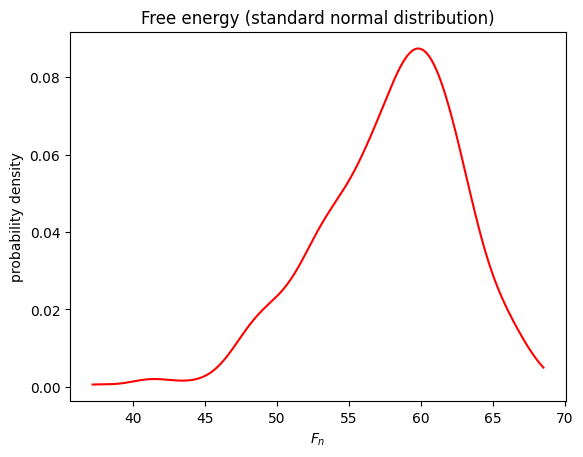

In [ ]:
def F(n, k):
  return -np.log(math.factorial(n-k) * math.factorial(k) / math.factorial(n+1))

m = 500
n = 100
T = []
for j in range(m):
  k = np.random.binomial(n=n, p=0.25)
  T.append(F(n, k))

kde = gaussian_kde(T)
x = np.linspace(min(T), max(T), 1000)

plt.plot(x, kde(x), color='red')
plt.title('Free energy (standard normal distribution)')
plt.xlabel('$F_n$')
plt.ylabel('probability density')
plt.show()

## 問題66

In [ ]:
from scipy.linalg import solve
# sklearn1.2からload_bostonは削除されたのでバージョンを下げる
!pip install scikit-learn==1.1.0
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
stan_code = """
data {
  int N;
  int M;
  vector[N] y;
  matrix[N, M] x;
  real beta;
}

parameters {
  vector[M] b;
  real <lower=0> sigma;
}

model {
  for (n in 1:N)
    target += beta * normal_lpdf(y[n] | x[n] * b, sigma);
}

generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | x[n]*b, sigma);
}
"""

In [ ]:
def bic(x, y):
    beta2 = solve(x.T @ x, x.T @ y)
    sigma2 = np.sum((y - x @ beta2) ** 2) / n
    return 0.5 * n * np.log(2 * np.pi * np.e * sigma2) + 0.5 * (p + 1) * np.log(n)

def wbic(log_likelihood):
    return -np.mean(np.sum(log_likelihood, axis=1))

In [ ]:
n = len(df)
m = 20
p = len(df.columns)  # 13
ones = np.ones(n).reshape(-1, 1)  # 切片用の1のベクトル
x = np.concatenate((ones, df.to_numpy()), axis=1)  # 説明変数
y = np.array(boston.target)  # 目的変数
data_list = {'N': n, 'M': p+1, 'y': y, 'x': x, 'beta': 1 / np.log(n)}
BIC = []
WBIC = []

for j in range(m):
    BIC.append(bic(x, y))
    stan_model = stan.build(stan_code, data=data_list, random_seed=1)
    fit = stan_model.sample(num_samples=3000)
    ms = fit.to_frame()
    log_lik = np.column_stack([ms[f'log_lik.{i+1}'] for i in range(n)])
    WBIC.append(wbic(log_lik))

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/16000)
Sampling:   0% (2/16000)
Sampling:   1% (101/16000)
Sampling:   1% (200/16000)
Sampling:   2% (300/16000)
Sampling:   2% (400/16000)
Sampling:   3% (500/16000)
Sampling:   4% (600/16000)
Sampling:   4% (700/16000)
Sampling:   5% (800/16000)
Sampling:   6% (900/16000)
Sampling:   6% (1000/16000)
Sampling:   7% (1100/16000)
Sampling:   8% (1200/16000)
Sampling:   8% (1300/16000)
Sampling:   9% (1400/16000)
Sampling:   9% (1500/16000)
Sampling:  10% (1600/16000)
Sampling:  11% (1700/16000)
Sampling:  11% (1800/16000)
Sampling:  12% (1901/16000)
Sampling:  13% (2002/16000)
Sampling:  13% (2101/16000)
Sampling:  14% (2200/16000)
Sampling:  14% (2300/16000)
Sampling:  15% (2400/16000)
S

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00055 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000163 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.
  Adjust your expectations accord

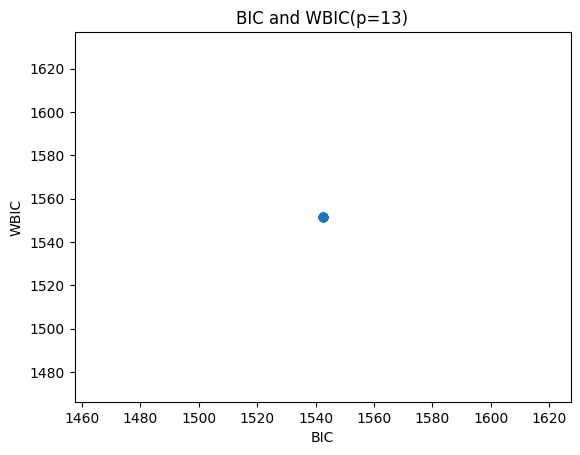

In [ ]:
plt.scatter(BIC, WBIC)
plt.title('BIC and WBIC(p=13)')
plt.xlabel('BIC')
plt.ylabel('WBIC')
plt.show()